# Исследование рынка стартапов с целью предсказания успешности стартапа

<b><i>Цель проекта:</i></b>
Разработать модель, которая предскажет какие из стартапов закроются.\
<b><i>Описание проекта:</i></b>
Имеем данные с информацией о стартапах, функционирующих в период с 1970 по 2018 годы.\
Датасет состоит из двух файлов: тренировочный и тестовый набор данных.\
Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

<i>Загрузим необходимые библиотеки:</i>

In [32]:
!pip install phik -q
!pip install shap -q

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns 
import numpy as np
import phik
import shap
import scipy.stats as st
from sklearn.model_selection import train_test_split
# загружаем класс pipeline:
from sklearn.pipeline import Pipeline, make_pipeline
# загружаем классы для подготовки данных:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
# загружаем нужные модели:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 

from sklearn.metrics import f1_score
# загружаем функцию для работы с метриками:
from sklearn.metrics import roc_auc_score
# импортируем класс RandomizedSearchCV:
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import RFECV

## Загрузка и ознакомление с данными

Файлы хранят следующую информацию:
- name - Название стартапа;
- category_list - Список категорий, к которым относится стартап;
- funding_total_usd - Общая сумма финансирования в USD;
- status - Статус стартапа (закрыт или действующий);
- country_code - Код страны;
- state_code - Код штата;
- region - Регион;
- city - Город;
- funding_rounds - Количество раундов финансирования;
- founded_at - Дата основания;
- first_funding_at - Дата первого раунда финансирования;
- last_funding_at - Дата последнего раунда финансирования;
- closed_at - Дата закрытия стартапа (если применимо);
- lifetime - Время существования стартапа в днях.

In [34]:
#Загрузка тренировочной выборки:
kaggle_startups_train = pd.read_csv('C:\Phyton\startups\kaggle_startups_train_27042024.csv')
kaggle_startups_train['category_list'].fillna('', inplace=True)
#Выгрузим первые 5 строк:
kaggle_startups_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaN


In [35]:
#Загрузка входных признаков тестовой выборки:
#Выгрузим первые 5 строк:
kaggle_startups_test = pd.read_csv('C:\Phyton\startups\kaggle_startups_test_27042024.csv')
#Выгрузим первые 5 строк:
kaggle_startups_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,6209


In [36]:
print('Размерность файла kaggle_startups_train', kaggle_startups_train.shape)
print('Размерность файла kaggle_startups_test', kaggle_startups_test.shape)

Размерность файла kaggle_startups_train (52514, 13)
Размерность файла kaggle_startups_test (13125, 12)


В тренировочной выборке 52514 строк и 13 столбцов; в тестовой выборке - 13125 строк и 12 столбцов.\
Целевым признаком является status - Статус стартапа (закрыт или действующий).\
В тестовой выборке есть показатель lifetime - время существования стартапа в днях, в то время как в тренировочной выборке такого показателя нет. Но на основе показателей closed_at и founded_at найдем lifetime. В случае, если closed_at не заполнен, укажем дату формирования выгрузки - '2018-01-01'.

## Предобработка данных

In [37]:
#Названия столбцов файла kaggle_startups_train:
kaggle_startups_train.columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at'],
      dtype='object')

In [38]:
#Названия столбцов файла kaggle_startups_test:
kaggle_startups_test.columns

Index(['name', 'category_list', 'funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'lifetime'],
      dtype='object')

Названия столбцов записаны верно.\
Выведим основную информацию по файлам и проверим корректность типов данных в них.

In [39]:
kaggle_startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52513 non-null  object 
 1   category_list      52514 non-null  object 
 2   funding_total_usd  42445 non-null  float64
 3   status             52514 non-null  object 
 4   country_code       47013 non-null  object 
 5   state_code         45752 non-null  object 
 6   region             46156 non-null  object 
 7   city               46156 non-null  object 
 8   funding_rounds     52514 non-null  int64  
 9   founded_at         52514 non-null  object 
 10  first_funding_at   52514 non-null  object 
 11  last_funding_at    52514 non-null  object 
 12  closed_at          4915 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [40]:
kaggle_startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   founded_at         13125 non-null  object 
 9   first_funding_at   13125 non-null  object 
 10  last_funding_at    13125 non-null  object 
 11  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 1.2+ MB


Показатели founded_at, first_funding_at, last_funding_at, closed_at имеют тип данных object - строки. С помощью метода to_datetime преобразуем их в формат datetime, заменив сначала пустые значения в closed_at на дату формирования выгрузки ('2018-01-01'). 

In [41]:
kaggle_startups_train['closed_at'].fillna('2018-01-01', inplace=True)

In [42]:
columns_to_process_train = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']

for column in columns_to_process_train:
    kaggle_startups_train[column] = pd.to_datetime(kaggle_startups_train[column])

#Проверим тип данных после преобразований:
kaggle_startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  object        
 1   category_list      52514 non-null  object        
 2   funding_total_usd  42445 non-null  float64       
 3   status             52514 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          52514 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [43]:
columns_to_process_test = ['founded_at', 'first_funding_at', 'last_funding_at']

for column in columns_to_process_test:
    kaggle_startups_test[column] = pd.to_datetime(kaggle_startups_test[column])

#Проверим тип данных после преобразований:
kaggle_startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   founded_at         13125 non-null  datetime64[ns]
 9   first_funding_at   13125 non-null  datetime64[ns]
 10  last_funding_at    13125 non-null  datetime64[ns]
 11  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(6)
memory usage: 1.2+ MB


Тип данных в файлах изменен корректно.\
Проверим на наличие пропущенных значений в датафреймах.

In [44]:
#Заменим пропуски в '' на Nan:
kaggle_startups_train = kaggle_startups_train.replace('', np.nan)

In [45]:
kaggle_startups_train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5501
state_code            6762
region                6358
city                  6358
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at                0
dtype: int64

В тренировочной выборке много пропусков. Проверим, есть ли стартапы, о которых отсутствует информация по нескольким показателям одновременно:

In [46]:
train_nan = kaggle_startups_train[(kaggle_startups_train['category_list'].isnull())  & (kaggle_startups_train['funding_total_usd'].isnull())  &\
                                  (kaggle_startups_train['country_code'].isnull()) & (kaggle_startups_train['state_code'].isnull()) &\
                                    (kaggle_startups_train['region'].isnull()) & (kaggle_startups_train['city'].isnull())]
train_nan.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2014-11-02
24,Savasti,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-02-27
64,Seamless Logistics,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2009-02-27,2011-02-01,2011-02-01,2018-01-01
78,Efficient Photon,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2011-03-10,2011-09-22,2011-09-22,2012-10-22
155,Public Post,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2007-10-15,2008-08-14,2008-08-14,2009-09-01
158,Little Bird GmbH,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2009-01-01,2014-10-01,2014-10-01,2018-01-01
323,Tarantula Labs,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-07-20,2015-08-21,2015-08-21,2016-12-18
348,Richslide,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2013-01-01,2014-10-14,2014-10-14,2018-01-01
394,Live Painter,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2012-06-10,2014-01-21,2014-01-21,2015-08-30
438,DiaKine Therapeutics,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2007-05-09,2008-09-03,2008-09-03,2018-01-01


In [47]:
print('Количество строк в таблице train_nan:', train_nan.shape[0])

Количество строк в таблице train_nan: 884


В тренировочной выборке 884 стартапа (1,68% от всего количества) по которым нет информации по таким показателям, как category_list (список категорий, к которым относится стартап), funding_total_usd (общая сумма финансирования в USD), country_code (код страны), state_code	(код штата), region (регион), city (город).\
По стартапам из таблицы train_nan известно только status (закрыт или нет), funding_rounds (количество раундов финансирования), founded_at (дата основания), first_funding_at (дата первого раунда финансирования), last_funding_at (дата последнего раунда финансирования), closed_at (дата закрытия стартапа (если применимо)). Т.е. в основном только даные о датах.\
Проверим, есть ли пропуски в данных в тестовой таблице и если есть, то есть такие стартапы, о которых известны только даты их деятельности.

In [48]:
#Количество пропусков в тестовой выборке:
kaggle_startups_test.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

In [49]:
test_null = kaggle_startups_test.query("category_list != category_list and funding_total_usd != funding_total_usd and country_code != country_code\
                                       and state_code != state_code and region != region and city != city")
print('Количество стартапов в тестовой выборке, о которых известны только данные о датах:', test_null.shape)

Количество стартапов в тестовой выборке, о которых известны только данные о датах: (224, 12)


Как видим, и в тренировочной выборке и в тестовой присутствует много пропусков в данных. В том числе и пропуски по нескольким показателям одновременно. Стоит отметить, что соотношение пропусков в показателях схожи в обеих выборках.\
В связи с тем, что мы не располагаем иной информацией и мы не можем заполнить пропуски реальными данными. Кроме того, такой объем пропущенных значений нецелесообразно заполнять, например, наиболее частым встречающимся, что приведет к искажению данных. Удалять такие стартапы из тренировочной выборки не будем.\
Заменим "Nan" на "unknown"  в обоих датафреймах. В показателе funding_total_USD больше 10 тыс. пропусков в тренировочной выборке, что составляет почти 20% от всех данных. Заменим пропуски на медианное значение показателя в обеих выборках. В случае, если показатель имеет большой разброс значений, среднее значение может быть завышенным.

In [50]:
columns_to_process_nan = ['category_list', 'country_code', 'state_code', 'region', 'city']

#Замена значения NaN на "unknown" в указанных столбцах в тренировочной выборке:
kaggle_startups_train[columns_to_process_nan] = kaggle_startups_train[columns_to_process_nan].fillna("unknown")

#Замена значения NaN на "unknown" в указанных столбцах в тестовой выборке:
kaggle_startups_test[columns_to_process_nan] = kaggle_startups_test[columns_to_process_nan].fillna("unknown")

#Замена Nan  в показателе funding_total_usd на среднее значение:
kaggle_startups_train['funding_total_usd'].fillna(kaggle_startups_train['funding_total_usd'].median(), inplace=True)
kaggle_startups_test['funding_total_usd'].fillna(kaggle_startups_test['funding_total_usd'].median(), inplace=True)

In [51]:
#Удалим из тренировочной выборки строку со стартапом, название которого неизвестно:
kaggle_startups_train = kaggle_startups_train.dropna(subset=['name'])

Проверим на наличие пропущенных значений в обеих выборках после преобразования:

In [52]:
kaggle_startups_train.isna().sum()

name                 0
category_list        0
funding_total_usd    0
status               0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
founded_at           0
first_funding_at     0
last_funding_at      0
closed_at            0
dtype: int64

In [53]:
kaggle_startups_test.isna().sum()

name                 0
category_list        0
funding_total_usd    0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
founded_at           0
first_funding_at     0
last_funding_at      0
lifetime             0
dtype: int64

Все пропущенные значения заменены на "unknown".\
Проверим датафреймы на наличие дубликатов.

In [54]:
print(f'Количество дубликатов в kaggle_startups_train:', kaggle_startups_train.duplicated().sum())
print(f'Количество дубликатов в kaggle_startups_test:', kaggle_startups_test.duplicated().sum())

Количество дубликатов в kaggle_startups_train: 0
Количество дубликатов в kaggle_startups_test: 0


Явных дубликатов в таблицах нет. Проверим на наличие неявных дубликатов:

In [55]:
#Уникальные значения нечисловых показателей в файле kaggle_startups_train:
print(f' Уникальные значения показателей в файле kaggle_startups_train')
print(f'"category_list":', kaggle_startups_train['category_list'].unique())
print(f'"country_code":', kaggle_startups_train['country_code'].unique())
print(f'"state_code":', kaggle_startups_train['state_code'].unique())
print(f'"region":', kaggle_startups_train['region'].unique())
print(f'"city":', kaggle_startups_train['city'].unique())

 Уникальные значения показателей в файле kaggle_startups_train
"category_list": ['Online Reservations|Restaurants' 'Manufacturing|Medical|Medical Devices'
 'Biotechnology' ... 'Gambling|Games|Online Gaming|Sports'
 'Aerospace|Mobile|Transportation|Travel'
 'Online Rental|Parking|Price Comparison']
"country_code": ['CHE' 'USA' 'unknown' 'GBR' 'RUS' 'ESP' 'FRA' 'SWE' 'IND' 'KOR' 'AUS'
 'TWN' 'CHN' 'HUN' 'CAN' 'FIN' 'BRA' 'EGY' 'PRT' 'ISR' 'CHL' 'SVK' 'NLD'
 'ARG' 'ARE' 'JPN' 'IRL' 'DEU' 'LBN' 'EST' 'IDN' 'BEL' 'MEX' 'DNK' 'ITA'
 'GRC' 'ROM' 'TUR' 'SGP' 'SAU' 'MYS' 'NGA' 'QAT' 'VNM' 'BGR' 'GHA' 'UGA'
 'JOR' 'AUT' 'PAK' 'NZL' 'HKG' 'ZAF' 'LVA' 'NOR' 'HRV' 'VEN' 'PER' 'LUX'
 'SVN' 'POL' 'PHL' 'NIC' 'CZE' 'ISL' 'PAN' 'URY' 'BGD' 'MCO' 'GTM' 'THA'
 'TTO' 'UKR' 'KEN' 'CRI' 'DZA' 'LTU' 'CYM' 'MUS' 'BLR' 'SLV' 'COL' 'MLT'
 'PSE' 'BLZ' 'CYP' 'MMR' 'MKD' 'KHM' 'GIB' 'SRB' 'DOM' 'BWA' 'BLM' 'PRY'
 'BMU' 'TAN' 'LIE' 'GRD' 'UZB' 'GEO' 'SEN' 'ALB' 'ECU' 'MOZ' 'LKA' 'LAO'
 'TUN' 'HND' 'ZWE' 'BAH' 'MDA'

Неявные дубликаты есть в показателе category_list, показатель содержит в одной категории несколько обозначений. В дальнейшем постараемся укрупнить категории.

In [56]:
#Уникальные значения нечисловых показателей в файле kaggle_startups_test:
print(f' Уникальные значения показателей в файле kaggle_startups_test')
print(f'"category_list":', kaggle_startups_test['category_list'].unique())
print(f'"country_code":', kaggle_startups_test['country_code'].unique())
print(f'"state_code":', kaggle_startups_test['state_code'].unique())
print(f'"region":', kaggle_startups_test['region'].unique())
print(f'"city":', kaggle_startups_test['city'].unique())

 Уникальные значения показателей в файле kaggle_startups_test
"category_list": ['Clean Technology' 'Hospitality' 'Finance' ...
 'Design|E-Commerce|Marketplaces|Printing'
 'Advertising Exchanges|Mobile|Mobile Advertising'
 'Communications Hardware|Messaging|Mobile|Office Space|Technology|VoIP']
"country_code": ['NIC' 'USA' 'LUX' 'CAN' 'unknown' 'MYS' 'DEU' 'GBR' 'FRA' 'ITA' 'CHN'
 'ARG' 'NLD' 'IRL' 'AUS' 'CHE' 'CHL' 'ESP' 'IND' 'ISR' 'DNK' 'KOR' 'RUS'
 'PHL' 'URY' 'SGP' 'BRA' 'EGY' 'MEX' 'POL' 'VNM' 'AUT' 'EST' 'BEL' 'DMA'
 'PRT' 'SWE' 'JOR' 'HUN' 'HKG' 'JPN' 'ZAF' 'COL' 'BGR' 'CZE' 'GRC' 'LTU'
 'TWN' 'ISL' 'IDN' 'FIN' 'NOR' 'ARE' 'UKR' 'KEN' 'NGA' 'TUR' 'CRI' 'THA'
 'CYP' 'ROM' 'MMR' 'VEN' 'BHR' 'NZL' 'SVK' 'CYM' 'LVA' 'MKD' 'PER' 'AZE'
 'BWA' 'BGD' 'ZWE' 'CIV' 'LKA' 'SVN' 'SRB' 'BLR' 'TAN' 'SAU' 'GHA' 'CMR'
 'TTO' 'PAK' 'BMU' 'PSE' 'UGA' 'MUS' 'JAM' 'LBN' 'ECU' 'PAN' 'GTM' 'HRV'
 'BRB' 'ZMB']
"state_code": ['17' 'TN' '3' 'CA' 'ON' 'unknown' 'VA' 'PA' 'AZ' '14' '7' 'AL' 'MA' 'NY'
 '16'

Неявные дубликаты могут содержаться также и в показателе region.\
Приступим к исследовательскому анализу данных.

## Исследовательский анализ данных

Проанализируем информацию, хранящуюся в тренировочной выборке.

In [57]:
#Сводная таблица по количеству стартапов разных категорий:
category_pivot_train = kaggle_startups_train.pivot_table(index='category_list', values='name', aggfunc='count').sort_values(by='name', ascending=False)
category_pivot_train.query('name >= 10').head(50)

,name
category_list,
Software,3207
Biotechnology,2905
unknown,2465
E-Commerce,1063
Mobile,920
Clean Technology,892
Curated Web,851
Health Care,744
Hardware + Software,733


В тренировочной выборке больше 22 тыс. уникальных значений категорий, к которым относится стартап. Большая часть из них мультикатегориальна. То есть включает в себя сразу несколько отраслей. 

In [58]:
#Сводная таблица по количеству стартапов разных категорий для тестовой выборки:
category_pivot_test = kaggle_startups_test.pivot_table(index='category_list', values='name', aggfunc='count').sort_values(by='name', ascending=False)
category_pivot_test

,name
category_list,
Software,775
Biotechnology,693
unknown,591
E-Commerce,263
Mobile,255
...,...
Cloud Computing|Linux|Software,1
Cloud Computing|Life Sciences|Pharmaceuticals|SaaS|Software Compliance,1
Cloud Computing|K-12 Education|SaaS|Software,1


Схожая картина с категориями наблюдается и в тестовой выборке.

In [59]:
kaggle_startups_train['funding_total_usd'].describe()

count    5.251300e+04
mean     1.513311e+07
std      1.683514e+08
min      1.000000e+00
25%      5.300000e+05
50%      2.000000e+06
75%      6.790000e+06
max      3.007950e+10
Name: funding_total_usd, dtype: float64

В среднем общая сумма финансирования стартапа составляет 18.249 млн.USD, при стандартном отклонении - 168 млн.USD. Столь большое стандартное отклонение говорит о сильном разбросе данных. При минимальном значении показателя в 1 USD, максимальное значение - 30,079 млрд.USD.

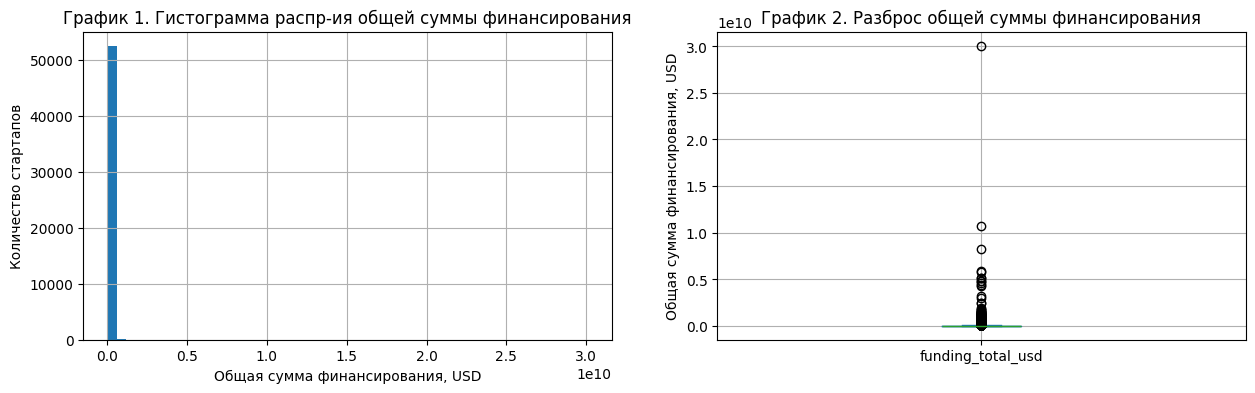

In [60]:
#гистограмма частотности распределения и "ящик с усами" для показателя funding_total_usd:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
kaggle_startups_train['funding_total_usd'].plot(kind='hist', bins=50, ax=axes[0], grid=True)
axes[0].set_title("График 1. Гистограмма распр-ия общей суммы финансирования")
axes[0].set_xlabel('Общая сумма финансирования, USD')
axes[0].set_ylabel('Количество стартапов')
kaggle_startups_train['funding_total_usd'].plot(kind='box', ax=axes[1], grid=True)
axes[1].set_title("График 2. Разброс общей суммы финансирования")
axes[1].set_ylabel('Общая сумма финансирования, USD')
plt.show()

"Ящик с усами" подтверждает наше предположение о сильном разбросе значений. Гистограмма распределения в данном случае неинформативна.\
Ограничим показатель 50 млн.USD

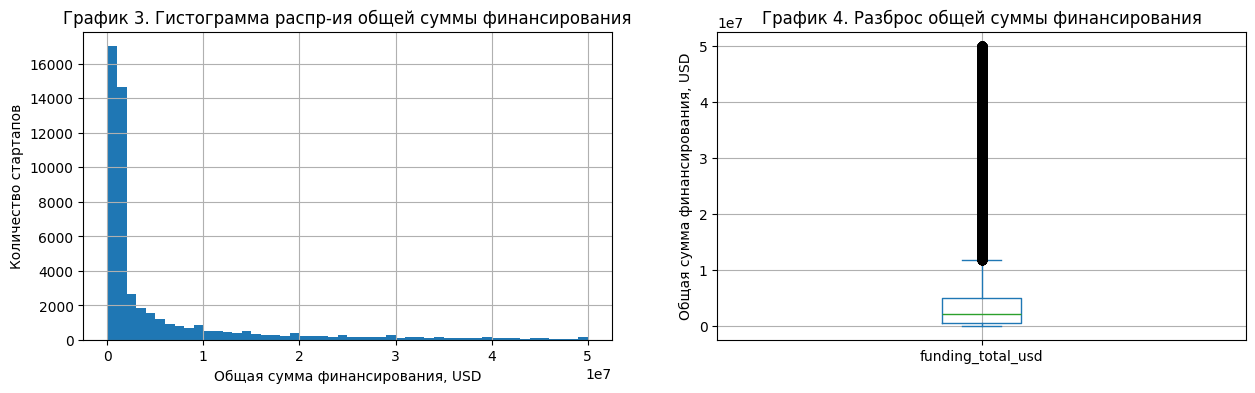

In [61]:
train_funding = kaggle_startups_train.query('funding_total_usd <= 50000000')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
train_funding['funding_total_usd'].plot(kind='hist', bins=50, ax=axes[0], grid=True)
axes[0].set_title("График 3. Гистограмма распр-ия общей суммы финансирования")
axes[0].set_xlabel('Общая сумма финансирования, USD')
axes[0].set_ylabel('Количество стартапов')
train_funding['funding_total_usd'].plot(kind='box', ax=axes[1], grid=True)
axes[1].set_title("График 4. Разброс общей суммы финансирования")
axes[1].set_ylabel('Общая сумма финансирования, USD')
plt.show()

На графике 3 видим, что большое количество стартапов имели сумму финансирования меньше 500 тыс. USD, а также больше 10 тыс. стартапов имели общую сумму финансирования чуть меньше 20 млн. USD.\
"Ящик с усами" показал, что сумма превышающая 45 млн.USD является аномальным выбросом.

Построим гистограмму рассеивания и boxplot для тестовой выборки.

In [62]:
kaggle_startups_test['funding_total_usd'].describe()

count    1.312500e+04
mean     1.369138e+07
std      8.282737e+07
min      1.000000e+00
25%      5.010000e+05
50%      2.000000e+06
75%      6.513865e+06
max      4.715000e+09
Name: funding_total_usd, dtype: float64

Медианные значения показателя обеих выборок схожи. В тестовой выборке разброс значений меньше: стандартное отклонение 82 млн.USD против 168 млн.USD в тренировочной выборке. 

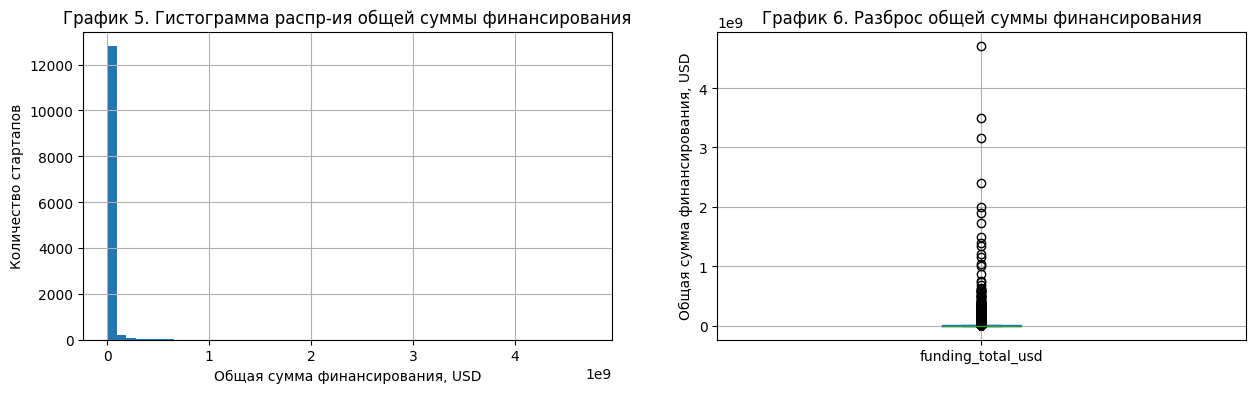

In [63]:
#гистограмма частотности распределения и "ящик с усами" для показателя funding_total_usd:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
kaggle_startups_test['funding_total_usd'].plot(kind='hist', bins=50, ax=axes[0], grid=True)
axes[0].set_title("График 5. Гистограмма распр-ия общей суммы финансирования")
axes[0].set_xlabel('Общая сумма финансирования, USD')
axes[0].set_ylabel('Количество стартапов')
kaggle_startups_test['funding_total_usd'].plot(kind='box', ax=axes[1], grid=True)
axes[1].set_title("График 6. Разброс общей суммы финансирования")
axes[1].set_ylabel('Общая сумма финансирования, USD')
plt.show()

Ограничим значения показателя 50 млн.USD

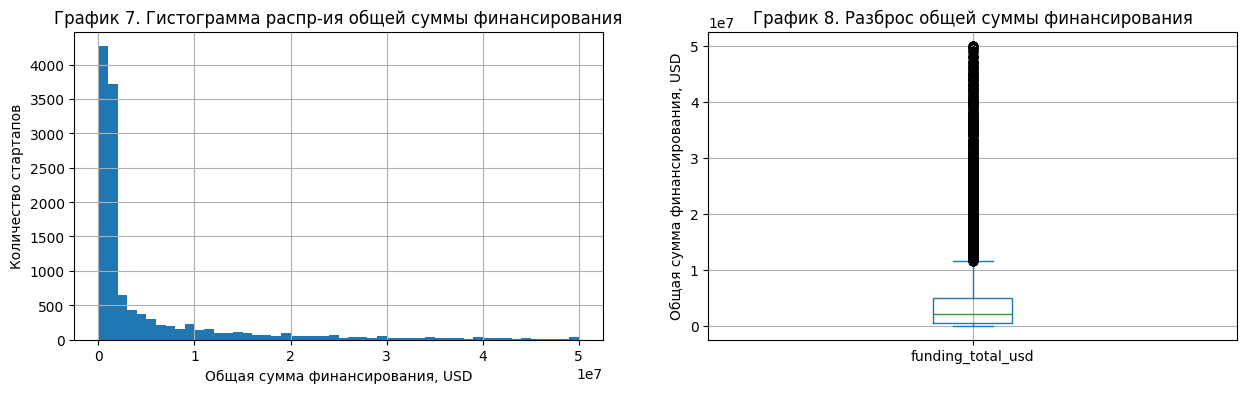

In [64]:
test_funding = kaggle_startups_test.query('funding_total_usd <= 50000000')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
test_funding['funding_total_usd'].plot(kind='hist', bins=50, ax=axes[0], grid=True)
axes[0].set_title("График 7. Гистограмма распр-ия общей суммы финансирования")
axes[0].set_xlabel('Общая сумма финансирования, USD')
axes[0].set_ylabel('Количество стартапов')
test_funding['funding_total_usd'].plot(kind='box', ax=axes[1], grid=True)
axes[1].set_title("График 8. Разброс общей суммы финансирования")
axes[1].set_ylabel('Общая сумма финансирования, USD')
plt.show()

Гистограмма распределения для тестовой выборки схожа с гистограммой распределения для тренировочной выборки.

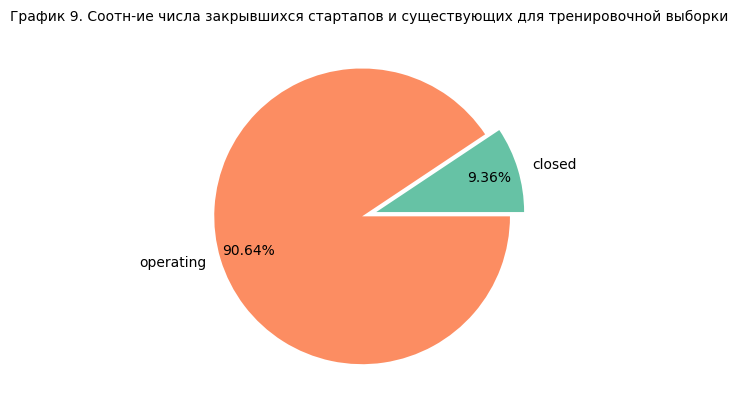

In [65]:
(
kaggle_startups_train
    .pivot_table(index='status', values='name', aggfunc='count')
    .plot(kind='pie',
          autopct='%1.2f%%', 
          textprops={'fontsize':8}, 
          colors=sns.color_palette('Set2'),
          legend=False,
          subplots=True,
          explode=[0.05, 0.05], 
          pctdistance=0.80, 
          fontsize=10,
          ylabel=''
)
)
plt.title("График 9. Соотн-ие числа закрывшихся стартапов и существующих для тренировочной выборки", fontsize=10)

plt.show()

Из 52 тыс. стартапов в тренировочной выборке на начало 2018 года закрыты меньше 10%.

In [66]:
train_country_pivot = kaggle_startups_train.pivot_table(index='country_code', values='name', aggfunc='count').sort_values(by='name', ascending=False)
train_country_pivot.columns = ['count']
#Рассчитаем процентное соотношение:
train_country_pivot['percent'] = train_country_pivot['count']\
                                          .apply(lambda x: x/train_country_pivot['count'].sum()*100).round(2)
train_country_pivot.head(20)

,count,percent
country_code,,
USA,29700,56.56
unknown,5501,10.48
GBR,2925,5.57
CAN,1540,2.93
IND,1276,2.43
CHN,1240,2.36
FRA,915,1.74
DEU,834,1.59
ISR,767,1.46


56.6% всех стартапов в тренировочной выборке открыты в USA. Нет информации о 10,5% стартапах. 5.6% зарегестрированы в United Kingdom, в Canada меньше 3% стартапов. В России зарегестрировано 369 стартапов, что составляет 0,7% тренировочной выборки.

Создадим сводную таблицу по странам, в которых зарегестрированы стартапы из тестовой выборки.

In [67]:
test_country_pivot = kaggle_startups_test.pivot_table(index='country_code', values='name', aggfunc='count').sort_values(by='name', ascending=False)
test_country_pivot.columns = ['count']
#Рассчитаем процентное соотношение:
test_country_pivot['percent'] = test_country_pivot['count']\
                                          .apply(lambda x: x/test_country_pivot['count'].sum()*100).round(2)
test_country_pivot.head(20)

,count,percent
country_code,,
USA,7428,56.59
unknown,1382,10.53
GBR,725,5.52
CAN,369,2.81
IND,307,2.34
CHN,301,2.29
DEU,237,1.81
FRA,213,1.62
ISR,190,1.45


В процентном соотношении разбивка стран для тестовой выборки схожа с тренировочной выборкой.

In [68]:
train_funding_rounds_pivot = (
    kaggle_startups_train
    .pivot_table(index='funding_rounds', values='name', aggfunc='count')
    .reset_index()
    .rename(columns = {'name': 'count_startups'}))

train_funding_rounds_pivot['percent'] = train_funding_rounds_pivot['count_startups']\
                                          .apply(lambda x: x/train_funding_rounds_pivot['count_startups'].sum()*100).round(2)

test_funding_rounds_pivot = (
    kaggle_startups_test
    .pivot_table(index='funding_rounds', values='name', aggfunc='count')
    .reset_index()
    .rename(columns = {'name': 'count_startups'}))

test_funding_rounds_pivot['percent'] = test_funding_rounds_pivot['count_startups']\
                                          .apply(lambda x: x/test_funding_rounds_pivot['count_startups'].sum()*100).round(2)


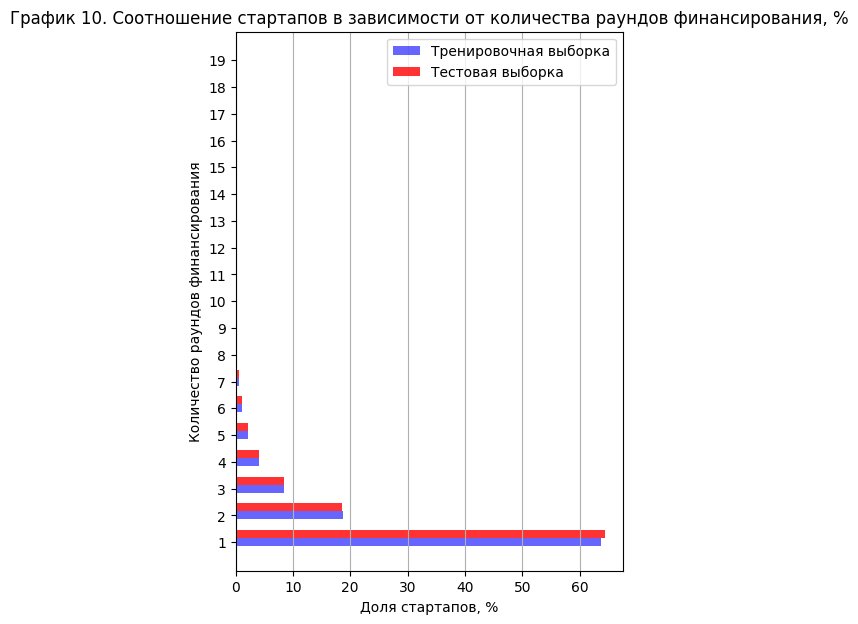

In [69]:
x_train_1 = train_funding_rounds_pivot['percent']
y_train_1 = train_funding_rounds_pivot['funding_rounds']

x_test_1 = test_funding_rounds_pivot['percent']
y_test_1 = test_funding_rounds_pivot['funding_rounds']

bw=0.3

plt.figure(figsize=(5, 7))

# Построение первого графика
plt.barh(y_train_1, x_train_1, bw, color='b', alpha=0.6, label='Тренировочная выборка')

# Построение второго графика
plt.barh(y_test_1+bw, x_test_1, bw, color='r', alpha=0.8, label='Тестовая выборка')

plt.yticks(y_train_1)
plt.xlabel('Доля стартапов, %')
plt.ylabel('Количество раундов финансирования')
plt.title('График 10. Соотношение стартапов в зависимости от количества раундов финансирования, %')
plt.legend() 
plt.grid(axis='x')

plt.show()


На графике 10 изображено процентное соотношение стартапов в зависимости от количества раундов финансирования. Как видим, графики практически идентичны, что говорит о том, что обе выборки схожи.\
Примерно 34 тыс. стартапов в тренировочно выборке (65%) имели 1 раунд финансирования. Чуть меньше 10 тыс.стартапов (19%) - 2 раунда финансирования. 4 тыс. стартапов (7%) - 3 раунда финансирования. 19 раундов финансирования имел всего 1 стартап.

Создадим новые признаки, указывающие на год жизнедеятельности компаний:

In [70]:
kaggle_startups_train['year_founded_at'] = kaggle_startups_train['founded_at'].dt.year
kaggle_startups_train['year_first_funding_at'] = kaggle_startups_train['first_funding_at'].dt.year
kaggle_startups_train['year_last_funding_at'] = kaggle_startups_train['last_funding_at'].dt.year

kaggle_startups_test['year_founded_at'] = kaggle_startups_test['founded_at'].dt.year
kaggle_startups_test['year_first_funding_at'] = kaggle_startups_test['first_funding_at'].dt.year
kaggle_startups_test['year_last_funding_at'] = kaggle_startups_test['last_funding_at'].dt.year


Рассчитаем процентное соотношение компаний в обеих выборках в зависимости от года основания:

In [71]:
#тренировочная выборка:

train_year_founded_at = (
    kaggle_startups_train.pivot_table(index='year_founded_at', values='name', aggfunc='count')
    .reset_index()
    .rename(columns = {'name': 'count_startups'})
)
train_year_founded_at['percent'] = train_year_founded_at['count_startups']\
                                          .apply(lambda x: x/train_year_founded_at['count_startups'].sum()*100).round(2)
 #тестовая выборка:
test_year_founded_at = (
    kaggle_startups_test.pivot_table(index='year_founded_at', values='name', aggfunc='count')
    .reset_index()
    .rename(columns = {'name': 'count_startups'})
)
test_year_founded_at['percent'] = test_year_founded_at['count_startups']\
                                          .apply(lambda x: x/test_year_founded_at['count_startups'].sum()*100).round(2)

Визуализируем полученную информацию:

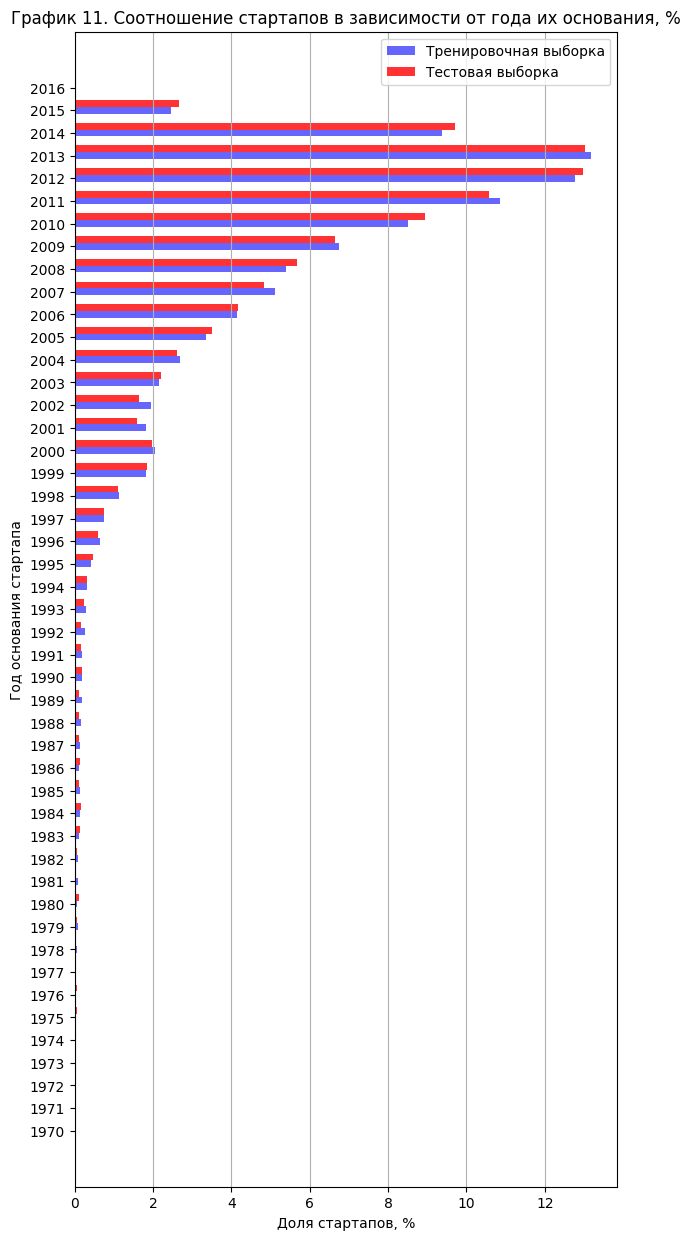

In [72]:
x_train_2 = train_year_founded_at['percent']
y_train_2 = train_year_founded_at['year_founded_at']

x_test_2 = test_year_founded_at['percent']
y_test_2 = test_year_founded_at['year_founded_at']

bw=0.3

plt.figure(figsize=(7, 15))

# Построение первого графика
plt.barh(y_train_2, x_train_2, bw, color='b', alpha=0.6, label='Тренировочная выборка')

# Построение второго графика
plt.barh(y_test_2+bw, x_test_2, bw, color='r', alpha=0.8, label='Тестовая выборка')

plt.yticks(y_train_2)
plt.xlabel('Доля стартапов, %')
plt.ylabel('Год основания стартапа')
plt.title('График 11. Соотношение стартапов в зависимости от года их основания, %')
plt.legend() 
plt.grid(axis='x')

plt.show()


Примерно 43% стартапов основаны до 2010 года. Наибольшее количество новых стартапов было открыто в 2012, 2013 годах.

В тренировочной выборке создадим столбец 'lifetime' - время существования стартапа в днях.

In [73]:
kaggle_startups_train['lifetime'] = (kaggle_startups_train['closed_at'] - kaggle_startups_train['founded_at']).dt.days

In [74]:
kaggle_startups_train['lifetime'].describe()

count    52513.000000
mean      3141.097500
std       2147.883071
min         17.000000
25%       1740.000000
50%       2557.000000
75%       4018.000000
max      17378.000000
Name: lifetime, dtype: float64

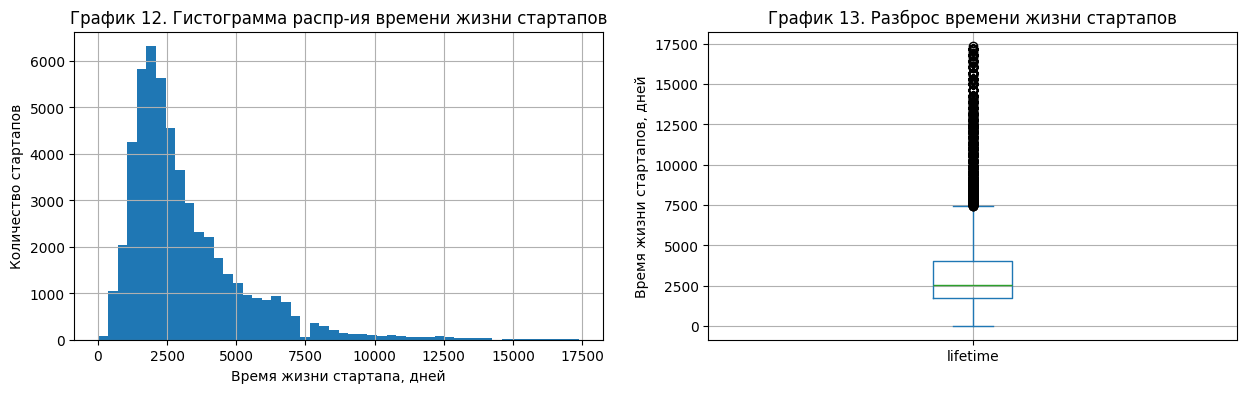

In [75]:
#гистограмма частотности распределения и "ящик с усами" для показателя lifetime:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
kaggle_startups_train['lifetime'].plot(kind='hist', bins=50, ax=axes[0], grid=True)
axes[0].set_title("График 12. Гистограмма распр-ия времени жизни стартапов")
axes[0].set_xlabel('Время жизни стартапа, дней')
axes[0].set_ylabel('Количество стартапов')
kaggle_startups_train['lifetime'].plot(kind='box', ax=axes[1], grid=True)
axes[1].set_title("График 13. Разброс времени жизни стартапов")
axes[1].set_ylabel('Время жизни стартапов, дней')
plt.show()

Стандартное отклонение показателя составляет 2147 дней, что говорит о сильном разбросе значений. Медианное значение составляет 2557 дней, при среднем - 3141 дней. Минимальное значение показателя - 17 дней, максимальное 17378 дней или больше 47 лет.\
На графике 13 видим, что нормальным значением lifetime для тренировочной выборки является 7500 дней или 20 лет. Время жизни больше этого периода является аномальным значением.

In [76]:
kaggle_startups_test['lifetime'].describe()

count    13125.000000
mean      3098.205638
std       2128.488789
min         79.000000
25%       1729.000000
50%       2526.000000
75%       3871.000000
max      17167.000000
Name: lifetime, dtype: float64

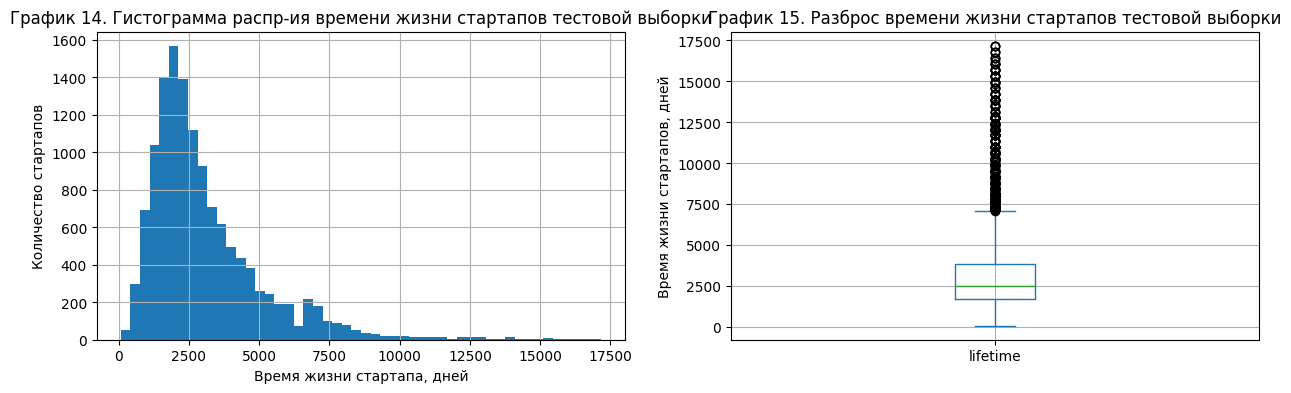

In [77]:
#гистограмма частотности распределения и "ящик с усами" для показателя lifetime для тестовой выборки:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
kaggle_startups_test['lifetime'].plot(kind='hist', bins=50, ax=axes[0], grid=True)
axes[0].set_title("График 14. Гистограмма распр-ия времени жизни стартапов тестовой выборки")
axes[0].set_xlabel('Время жизни стартапа, дней')
axes[0].set_ylabel('Количество стартапов')
kaggle_startups_test['lifetime'].plot(kind='box', ax=axes[1], grid=True)
axes[1].set_title("График 15. Разброс времени жизни стартапов тестовой выборки")
axes[1].set_ylabel('Время жизни стартапов, дней')
plt.show()

Схожая картина наблюдается и в тестовой выборке. Разброс значений также большой - от 79 до 17167 дней. Медианное значение показателя - 2526 дней или чуть меньше 7 лет.

На основе проведенного анализа можем сделать вывод, что тестовая выборка и тренировочная схожи между собой. В данных нет существенных различий в части распределений признаков.

Построим матрицу корреляции с целью выявить взаимосвязь между признаками в количественном выражении:

In [78]:
kaggle_startups_train.columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at', 'year_founded_at',
       'year_first_funding_at', 'year_last_funding_at', 'lifetime'],
      dtype='object')

In [110]:
#отберем показатели, которые войдут в матрицу корреляции:
train_columns_1 = ['name', 
                   'category_list',
                   'funding_total_usd',
                    'status', 
                    'city',
                    'country_code', 
                    'funding_rounds', 
                    'year_founded_at', 
                    'year_last_funding_at',
                    'lifetime']
data_train = kaggle_startups_train[train_columns_1]
#преобразуем столбец 'name' в индекс:
data_train = data_train.set_index('name')

C:\Users\Ноутбуки77ru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable category_list is large: 22109. Are you sure this is not an interval variable? Analysis for pairs of variables including category_list can be slow.
  warnings.warn(


Text(0.5, 1.0, 'График 16. Тепловая карта для матрицы корреляции $\\phi_K$ признаков в data_train_1')

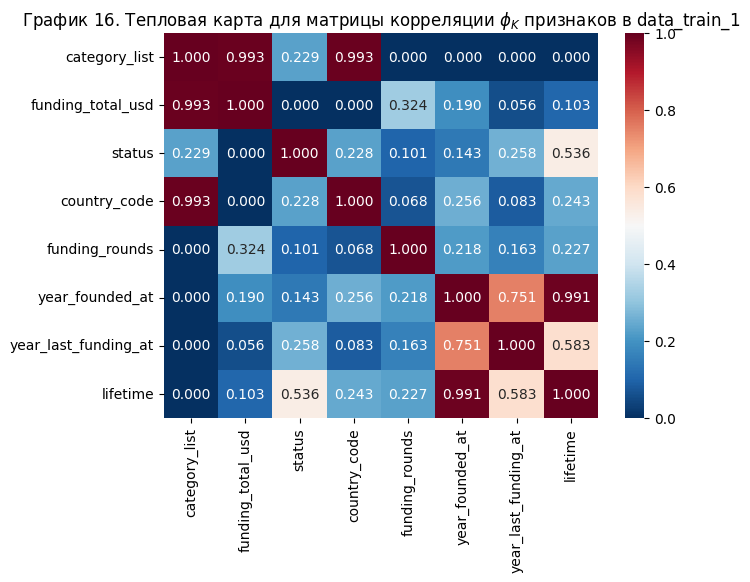

In [111]:
# создадим список с наименованиями непрерывных признаков:
interval_cols = ['funding_total_usd', 'lifetime']

plt.subplots(figsize=(7, 5))
sns.heatmap(data_train.drop('city', axis=1).phik_matrix(interval_cols=interval_cols), fmt='.3f', cmap='RdBu_r', annot=True)
plt.title('График 16. Тепловая карта для матрицы корреляции $\phi_K$ признаков в data_train_1', fontsize=12)


Целевой признак status больше всего коррелирует с показателем lifetime, коэфффициент корреляции 0,536. Показатель status совсем некоррелирует с признаком funding_total_usd, кроме того funding_total_usd мультиколлинеарен с category_list. В дальнейшем создадим синтетический признак на его основе.\
Также признаки lifetime и year_founded_at мультиколлиниарны. Исключим из модели признак year_founded_at, т.к. связь с целевым признаком у него слабая.

In [112]:
#отберем показатели, которые войдут в data_test:
test_columns_1 = ['name', 
                   'category_list',
                   'funding_total_usd',
                   'country_code', 
                   'city',
                    'funding_rounds', 
                    'year_founded_at', 
                    'year_last_funding_at',
                    'lifetime']
data_test = kaggle_startups_test[test_columns_1]
#преобразуем столбец 'name' в индекс:
data_test = data_test.set_index('name')

## Создание синтетических признаков

На основе признака funding_total_usd введем категориальный признак category_funding_total_usd:
- от 0 до 1000000,
- от 1.000.000 до 5.000.000,
- от 5.000.000 до 10.000.000,
- от 10.000.000 до 50.000.000,
- от 50.000.000 до 100.000.000,
- от 100.000.000 до 200.000.000,
- от 200.000.000 до 500.000.000,
- от 500.000.000 до 1.000.000.000,
- от 1.000.000.000 до 5.000.000.000

In [113]:
# Определим интервалы и метки для категорий
bins = [0, 1000000, 5000000, 10000000, 50000000, 100000000, 200000000, 500000000, 1000000000, 5000000000]
labels = ['0-1M', '1M-5M', '5M-10M', '10M-50M', '50M-100M', '100M-200M', '200M-500M', '500M-1B', '1B-5B']

In [114]:
# Преобразование числового показателя в категориальный
data_train['category_funding_total_usd'] = pd.cut(data_train['funding_total_usd'], bins=bins, labels=labels)
data_test['category_funding_total_usd'] = pd.cut(data_test['funding_total_usd'], bins=bins, labels=labels)
data_train.head()

,category_list,funding_total_usd,status,city,country_code,funding_rounds,year_founded_at,year_last_funding_at,lifetime,category_funding_total_usd
name,,,,,,,,,,
Lunchgate,Online Reservations|Restaurants,828626.0,operating,Zürich,CHE,2,2009,2014,2923,0-1M
EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,Redwood City,USA,4,2005,2014,4748,10M-50M
Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,San Jose,USA,3,2006,2014,4383,10M-50M
Sancilio and Company,Health Care,22250000.0,operating,unknown,unknown,3,2004,2014,5114,10M-50M
WireTough Cylinders,Manufacturing,2000000.0,operating,Bristol,USA,1,2010,2012,2650,1M-5M


Введем категориальный признак на основе показателя funding_rounds: category_funding_rounds_usd.

In [115]:
data_train['funding_rounds'].unique()

array([ 2,  4,  3,  1,  5,  7,  9,  6,  8, 10, 11, 12, 15, 13, 16, 17, 14,
       18, 19], dtype=int64)

In [116]:
# Определим интервалы и метки для категорий
bins_funding_rounds = [0, 1, 2, 3, 4, 5, 10, 15, 19]
labels_funding_rounds = ['1', '2', '3', '4', '5', '5-10', '10-15', '15-19']

In [117]:
# Преобразование числового показателя в категориальный
data_train['category_funding_rounds_usd'] = pd.cut(data_train['funding_rounds'], bins=bins_funding_rounds, labels=labels_funding_rounds)
data_test['category_funding_rounds_usd'] = pd.cut(data_test['funding_rounds'], bins=bins_funding_rounds, labels=labels_funding_rounds)
data_train.head()

,category_list,funding_total_usd,status,city,country_code,funding_rounds,year_founded_at,year_last_funding_at,lifetime,category_funding_total_usd,category_funding_rounds_usd
name,,,,,,,,,,,
Lunchgate,Online Reservations|Restaurants,828626.0,operating,Zürich,CHE,2,2009,2014,2923,0-1M,2
EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,Redwood City,USA,4,2005,2014,4748,10M-50M,4
Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,San Jose,USA,3,2006,2014,4383,10M-50M,3
Sancilio and Company,Health Care,22250000.0,operating,unknown,unknown,3,2004,2014,5114,10M-50M,3
WireTough Cylinders,Manufacturing,2000000.0,operating,Bristol,USA,1,2010,2012,2650,1M-5M,1


Создадим показатель continent_code на основе показателя country_code:

In [118]:
country_continent_mapping = {
    'CHE': 'Europe',
    'GBR': 'Europe',
    'RUS': 'Europe',
    'ESP': 'Europe',
    'FRA': 'Europe',
    'SWE': 'Europe',
    'HUN': 'Europe',
    'FIN': 'Europe',
    'PRT': 'Europe',
    'ISR': 'Europe',
    'SVK': 'Europe',
    'NLD': 'Europe',
    'IRL': 'Europe',
    'DEU': 'Europe',
    'LBN': 'Europe',
    'EST': 'Europe',
    'BEL': 'Europe',
    'DNK': 'Europe',
    'ITA': 'Europe',
    'GRC': 'Europe',
    'ROM': 'Europe',
    'TUR': 'Europe',
    'AUT': 'Europe',
    'UKR': 'Europe',
    'HRV': 'Europe',
    'LVA': 'Europe',
    'NOR': 'Europe',
    'POL': 'Europe',
    'CZE': 'Europe',
    'ISL': 'Europe',
    'MCO': 'Europe',
    'LUX': 'Europe',
    'SVN': 'Europe',
    'LTU': 'Europe',
    'CYP': 'Europe',
    'BLR': 'Europe',
    'MDA': 'Europe',
    'MKD': 'Europe',
    'USA': 'North America',
    'CAN': 'North America',
    'IND': 'Asia',
    'KOR': 'Asia',
    'AUS': 'Asia',
    'TWN': 'Asia',
    'CHN': 'Asia',
    'IDN': 'Asia',
    'MYS': 'Asia',
    'VNM': 'Asia',
    'SGP': 'Asia',
    'SAU': 'Asia',
    'JPN': 'Asia',
    'LKA': 'Asia',
    'KAZ': 'Asia',
    'EGY': 'Africa',
    'ZAF': 'Africa',
    'GHA': 'Africa',
    'NGA': 'Africa',
    'UGA': 'Africa',
    'ARE': 'The Middle East',
    'LBN': 'The Middle East',
    'BRA': 'South America',
    'ARG': 'South America',
    'unknown': 'unknown'
  
}

# Функция для преобразования кода стран в континент
def map_country_to_continent(country_code):
    return country_continent_mapping.get(country_code, 'Other')

# Применяем функцию к столбцу с кодами стран
data_train['continent'] = data_train['country_code'].apply(map_country_to_continent)
data_test['continent'] = data_test['country_code'].apply(map_country_to_continent)

data_train.head()

,category_list,funding_total_usd,status,city,country_code,funding_rounds,year_founded_at,year_last_funding_at,lifetime,category_funding_total_usd,category_funding_rounds_usd,continent
name,,,,,,,,,,,,
Lunchgate,Online Reservations|Restaurants,828626.0,operating,Zürich,CHE,2,2009,2014,2923,0-1M,2,Europe
EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,Redwood City,USA,4,2005,2014,4748,10M-50M,4,North America
Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,San Jose,USA,3,2006,2014,4383,10M-50M,3,North America
Sancilio and Company,Health Care,22250000.0,operating,unknown,unknown,3,2004,2014,5114,10M-50M,3,unknown
WireTough Cylinders,Manufacturing,2000000.0,operating,Bristol,USA,1,2010,2012,2650,1M-5M,1,North America


На основе признака category_list создадим признак category, куда включим основные направления бизнеса:

In [119]:
def asscign_category(row):
    if '3D' in row['category_list'] or 'Apps' in row['category_list'] or 'Internet' in row['category_list'] or\
        'Mobile' in row['category_list'] or 'App Marketing' in row['category_list'] or 'iPhone' in row['category_list'] or\
            'iPad' in row['category_list'] or 'iOS' in row['category_list'] or 'Wireless' in row['category_list']\
                or 'Web' in row['category_list'] or 'Wearables' in row['category_list'] or 'Virtual' in row['category_list']\
                    or 'Video' in row['category_list'] or 'Utilities' in row['category_list'] or 'Software' in row['category_list']\
                        or 'Semiconductors' in row['category_list'] or 'Messaging' in row['category_list']\
                            or 'Information Technology' in row['category_list'] or 'Search' in row['category_list']\
                                or 'Automotive' in row['category_list'] or 'Consumer Electronics' in row['category_list'] or 'Electronics'\
                                    in row['category_list'] or 'SaaS' in row['category_list']:
        return 'IT'
    if 'mHealth' in row['category_list'] or 'Veterinary' in row['category_list'] or 'Active Lifestyle' in row['category_list']\
        or 'Medical' in row['category_list'] or 'Health' in row['category_list'] or 'Biotechnology' in row['category_list']\
            or 'Hospitality' in row['category_list'] or 'Pharmaceuticals' in row['category_list']\
                or 'Nanotechnology' in row['category_list'] or 'Hospital' in row['category_list'] or 'Bio-Pharm' in row['category_list']\
                    or 'Environmental Innovation' in row['category_list']:
        return 'Health'
    if 'Finance' in row['category_list'] or 'Marketing' in row['category_list'] or 'Analytics' in row['category_list']\
        or 'Venture' in row['category_list'] or 'Accounting' in row['category_list'] or 'Consulting' in row['category_list']\
            or 'E-Commerce' in row['category_list'] or 'Financial' in row['category_list'] or 'Transportation' in row['category_list'] or \
                'Legal' in row['category_list'] or 'Banking' in row['category_list']:
        return 'Finance'
    if 'Sport' in row['category_list']:
        return 'Sport'
    if 'Tourism' in row['category_list'] or 'Travel' in row['category_list']:
        return 'Tourism'
    if 'Restaurant' in row['category_list'] or 'Hotel' in row['category_list'] or 'Wine' in row['category_list'] or 'Food' in row['category_list']:
        return 'Hotel and Restaurant'
    if 'Education' in row['category_list']:
        return 'Education'
    if 'The Service Sector' in row['category_list'] or 'Sales ' in row['category_list'] or 'Wholesale' in row['category_list']\
        or 'Fitness' in row['category_list'] or 'Ad Targeting' in row['category_list'] or 'Watch' in row['category_list']\
            or 'Clean Technology' in row['category_list'] or 'Advertising Networks' in row['category_list'] or 'Advertising'\
                in row['category_list'] or 'Game' in row['category_list'] or 'Fashion' in row['category_list']\
                    or 'News' in row['category_list'] or 'Music' in row['category_list'] or 'Photography' in row['category_list']\
                        or 'Services' in row['category_list'] or 'Design' in row['category_list'] or 'Entertainment' in row['category_list']\
                            or 'Telecommunications' in row['category_list'] or 'Retail' in row['category_list']\
                                or 'Consumer Goods' in row['category_list'] or 'Marketplaces' in row['category_list'] or 'Pets' in row['category_list']\
                                    or 'Media' in row['category_list'] or 'Logistics' in row['category_list'] or 'Consumers'\
                                        in row['category_list'] or 'Shopping' in row['category_list'] or 'Publishing' in row['category_list']\
                                            or 'Beauty' in row['category_list']:
        return 'The sphere of Goods and Services'
    if 'Social' in row['category_list'] or 'Wedding' in row['category_list'] or 'Women' in row['category_list']\
        or 'Young Adults' in row['category_list'] or 'Recruiting' in row['category_list'] or 'Public Relations' in row['category_list']\
            or 'Nonprofits' in row['category_list'] or 'Networking' in row['category_list'] or 'Human' in row['category_list']:
        return 'Social'
    if 'Water' in row['category_list']:
        return 'Agricultural'
    if 'Advanced Materials' in row['category_list'] or 'Real Estate' in row['category_list'] or 'Manufacturing' in row['category_list']:
        return 'Construction'
    if 'Security' in row['category_list']:
        return 'Insurance'
    if 'Energy' in row['category_list'] or 'Technology' in row['category_list'] or 'Alumni' in row['category_list'] or 'Oil' in row['category_list']:
        return 'Industry and Energy'
    if 'Local Businesses' in row['category_list'] or 'Startups' in row['category_list']:
        return 'Small Business'
    else: return 'Other'

    
data_train['category_new'] = data_train.apply(asscign_category, axis=1)
data_test['category_new'] = data_test.apply(asscign_category, axis=1)
data_train.head()

,category_list,funding_total_usd,status,city,country_code,funding_rounds,year_founded_at,year_last_funding_at,lifetime,category_funding_total_usd,category_funding_rounds_usd,continent,category_new
name,,,,,,,,,,,,,
Lunchgate,Online Reservations|Restaurants,828626.0,operating,Zürich,CHE,2,2009,2014,2923,0-1M,2,Europe,Hotel and Restaurant
EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,Redwood City,USA,4,2005,2014,4748,10M-50M,4,North America,Health
Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,San Jose,USA,3,2006,2014,4383,10M-50M,3,North America,Health
Sancilio and Company,Health Care,22250000.0,operating,unknown,unknown,3,2004,2014,5114,10M-50M,3,unknown,Health
WireTough Cylinders,Manufacturing,2000000.0,operating,Bristol,USA,1,2010,2012,2650,1M-5M,1,North America,Construction


In [133]:
#показатели из тренировочной и тестовой выборки, которые войдут в модель прогнозирования:
data_train_1 = data_train.drop(['funding_total_usd', 'year_founded_at', 'funding_rounds', 'country_code', 'category_list',\
                                'year_last_funding_at'], axis=1)
data_test_1 = data_test.drop(['funding_total_usd', 'year_founded_at', 'funding_rounds', 'country_code', 'category_list',\
                              'year_last_funding_at'], axis=1)
data_train_1.columns

Index(['status', 'city', 'lifetime', 'category_funding_total_usd',
       'category_funding_rounds_usd', 'continent', 'category_new'],
      dtype='object')

На графике 15 мы отмечали, что время жизни стартапа свыше 7500 является аномальным выбросом. Оставим в data_train_2 только стартапы, которые существуют менее 7500 дней.

In [134]:
data_train_2 = data_train_1.query('lifetime < 7500')

Имеющиеся признаки мы можем разделить на следующие две категории:
Категориальные бинарные признаки: category_funding_total_usd, category_funding_rounds_usd, continent, category_new, city. Кодирование будем проводить посредством метода OneHotEncoder().\
Числовые признаки: lifetime. Масштабирование проведем с помощью StandardScaler().

## Подготовка данных

In [135]:
#Разделим выборку на тренировочную и валидационную:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_valid, y_train, y_valid = train_test_split(
    data_train_2.drop(['status'], axis=1),
    data_train_2['status'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = data_train_2['status']
)

X_train.shape, X_valid.shape

((37727, 6), (12576, 6))

In [136]:
X_test = data_test_1
X_test.shape

(13125, 6)

In [137]:
# создадим экземпляр класса LabelEncoder для кодирования целевого признака:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print("Уникальные значения:", label_encoder.classes_)
print("Метки для каждого уникального значения:", label_encoder.transform(label_encoder.classes_))

Уникальные значения: ['closed' 'operating']
Метки для каждого уникального значения: [0 1]


In [138]:
# обучим модель и трансформируем тренировочную выборку:
y_train = label_encoder.fit_transform(y_train)

#трансформируем валидационную выборку:
y_valid = label_encoder.transform(y_valid)

Введём обозначения для типов исходных данных:

In [139]:
ohe_columns = ['category_funding_total_usd', 'category_funding_rounds_usd', 'continent', 'category_new', 'city']
num_columns = ['lifetime'] 

In [140]:
#Добавляем OHE-кодирование в пайплайн:
ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
) 

In [141]:
# создаем общий пайплайн для подготовки данных::
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
) 

In [142]:
#создаем итоговый пайплайн:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
        #словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
       'models__n_neighbors': range(5, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    #словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
        random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1',
            C=1
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    #словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel = 'poly',
            probability=True
        )],
        'models__degree': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [143]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    scoring = 'f1_weighted', 
    random_state=RANDOM_STATE, 
   n_jobs=-1
)

In [144]:
randomized_search.fit(X_train, y_train) 

print('Метрика для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Метрика для лучшей модели:
 0.9438582288093477

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['category_funding_total_usd',
                                                   'category_funding_rounds_usd',
                                                   'continent', 'category_new',
                                                   'city']),
                                                 ('num', 'passthrough',
                                                  ['lifetime'])])),
                ('models', KNeighborsClassifier

С помощью RandomizedSearchCV() нашли модель, которая наилучшим образом прогнозирует целевой признак - KNeighborsClassifier(n_neighbors=7). Метрика f1_score для наилучшей модели - 0,944, что является неплохим показателем.\
Проверим, как себя поведет модель на валидационных данных:

In [148]:
y_valid_pred = randomized_search.predict(X_valid)

C:\Users\Ноутбуки77ru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [149]:
f1_1 = f1_score(y_valid, y_valid_pred)
f1_1

0.9724221663342295

На валидационной выборке метрика равна 0,972. Получим предсказания на тестовых данных:

In [150]:
y_test_1 = randomized_search.predict(X_test)
y_test_1 = pd.DataFrame(y_test_1)
y_test_1 = y_test_1.replace({1: 'operating', 0: 'closed'})
y_test_1 = y_test_1.rename(columns={0: 'status'})
y_test_1.head()

C:\Users\Ноутбуки77ru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,status
0,operating
1,operating
2,operating
3,operating
4,operating


In [151]:
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
probabilities_one

C:\Users\Ноутбуки77ru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([1.        , 1.        , 0.85714286, ..., 1.        , 0.85714286,
       1.        ])

In [152]:
data_test_name = kaggle_startups_test['name']
test = pd.concat([data_test_name, y_test_1], axis=1)
#test = test.rename(columns={0: 'status'})
test.pivot_table(index='status', values='name', aggfunc='count')

,name
status,
closed,903
operating,12222


Сформируем итоговый файл с указанием названия стартапа и предсказанного статуса.

In [155]:
test.to_csv('result_end.csv', index=False)

## Общий вывод

Мы провели анализ данных о стартапах, созданных с 1970 по 2008 года. В нашем распоряжении были две выборки: тренировочная с 52 тыс. записей и тестовая с 13 тыс. записей.\
В ходе исследования выяснили, что из рассматриваемых стартапов в тренировочной выборке закрыты меньше 10%, остальные компании функционируют.\
Кроме того, время жизни стартапа считается нормальным, если оно меньше 7500 дней или 20 лет. Стартапы, существующие дольший срок являются аномальным выбросом.\
В среднем общая сумма финансирования стартапа из тренировочной выборки составляет 18.249 млн.USD, при стандартном отклонении - 168 млн.USD -  символизирующем большой разброс значений. При минимальном значении показателя в 1 USD, максимальное значение - 30,079 млрд.USD. Медианные значения показателя обеих выборок схожи. В тестовой выборке разброс значений меньше: стандартное отклонение 82 млн.USD.\
Больше 56% стартапов зарегистрированы в США, нет информации о стране регистрации для 10% компаний. В Великобритании зарегистрировано 5,5%, в России меньше 1%.\
65% компаний имели 1 раунд финансирования, 18% - 2 раунда, больше 8 раундо финансирования имели единичные компании.\
Примерно 43% стартапов основаны до 2010 года. Наибольшее количество новых стартапов было открыто в 2012, 2013 годах.\
Матрица корреляции признаков показала, что целевой показатель status в большей мере зависит от показателя lifetime (коэффициент корреляции - 0,536).\
В ходе работы были созданы ряд синтетических категориальных признаков: информация о континенте, на основе признака funding_total_usd ввели категориальный признак category_funding_total_usd, на основе информации о категории бизнесса ввели укрупненный признак category_new, а также на основе признака funding_rounds - category_funding_rounds_usd.\
Был подготовлен пайплайн, в котором прописаны процедуры масштабирования числовых признаков с помощью StandardScaler() и масштабирование категориальных признаков с помощью OneHotEncoder().\
С помощью RandomizedSearchCV() нашли модель, которая наилучшим образом прогнозирует целевой признак - KNeighborsClassifier(n_neighbors=7). Метрика f1_score для наилучшей модели - 0,944, что является неплохим показателем. На валидационной выборке метрика - 0,972.\
Итоговый файл с указанием названия стартапа и прогнозируемым статусом сформирован result_end.csv.